# 1. Exploratory Network Analysis (ENA)

In this notebook, we perform an exploratory analysis of the raw **MathOverflow answer-to-question** dataset (`sx-mathoverflow-a2q`) from the SNAP database.  
This step precedes any filtering and aims to:

- understand the global structure of the unfiltered interaction graph  
- compute fundamental network statistics  
- inspect temporal activity patterns  
- justify later decisions on subset construction  
- compare raw properties to known results from the literature  

This analysis provides the baseline from which all subsequent processing and structural evaluation will follow.


## 1.1 Dataset Overview

We work with the `sx-mathoverflow-a2q` dataset, which contains **answers to questions**:  
each row represents a timestamped interaction `(u, v, t)`, meaning:

- user **u** answered  
- a question originally posted by **v**  
- at time **t** (UNIX timestamp)

This dataset is a curated subset of the full MathOverflow interaction log, isolating the most meaningful "knowledge-transfer" edges.

According to the SNAP documentation, the dataset includes:

- **21,688 nodes** (unique users)  
- **107,581 temporal answer events**  
- **90,489 static directed edges** (after collapsing duplicates)

In this section, we load the raw dataset and compute initial descriptive statistics.


## 1.2 Loading the Dataset

We begin by loading the raw `sx-mathoverflow-a2q` dataset from the `data/` directory.

The file contains three columns separated by spaces: `source`, `target`, and `timestamp`.



In [171]:
import pandas as pd

df = pd.read_csv("../data/sx-mathoverflow.txt", delim_whitespace=True, header=None, names=["source", "target", "timestamp"])
df.head()

C:\Users\tiago\AppData\Local\Temp\ipykernel_23380\1272690245.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("../data/sx-mathoverflow.txt", delim_whitespace=True, header=None, names=["source", "target", "timestamp"])


,source,target,timestamp
0,1,4,1254192988
1,3,4,1254194656
2,1,2,1254202612
3,25,1,1254232804
4,14,16,1254263166


> A pandas DataFrame makes manipulation easier.


## 1.3 Basic Data Checks

Once loaded, we inspect:

- the shape of the dataset   
- count of unique users  
- total number of interactions

This allows us to confirm that the dataset matches the expected SNAP statistics and ensures data integrity before constructing the network.


In [174]:
df.shape

(506550, 3)

In [175]:
n_users = len(pd.unique(df[['source','target']].values.ravel()))
n_users

24818

In [176]:
n_events = len(df)
n_events

506550

## 1.4 Temporal Structure of the Interactions

Since each interaction includes a UNIX timestamp, we can extract temporal patterns.

In this section, we:
- convert timestamps into human-readable datetime objects  
- extract year and month  
- compute interaction volume per year  
- visualize how MathOverflow activity evolves over time  

This will later help justify the selection of the **2010–2012** window for the network subset.


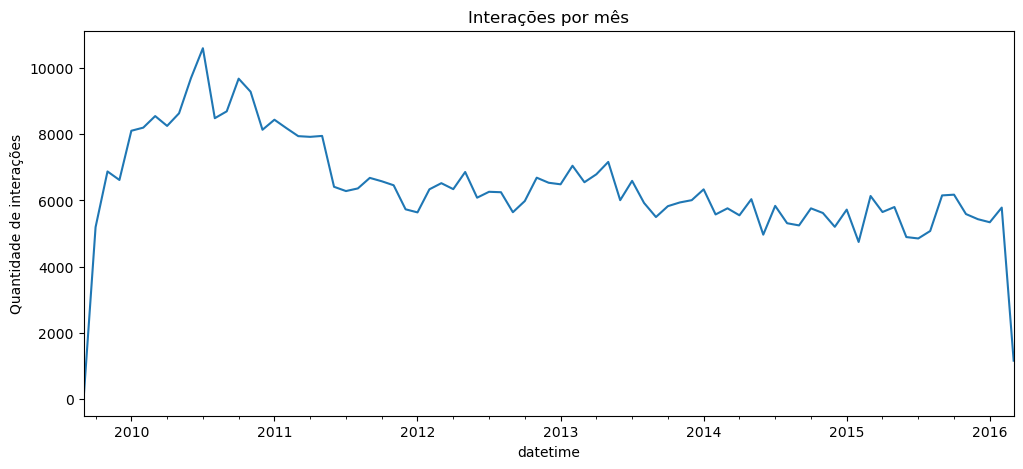

In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime

df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

df = df.set_index("datetime")
interactions_by_month = df.resample('ME').size()

plt.figure(figsize=(12, 5))
interactions_by_month.plot()
plt.title("Interações por mês")
plt.ylabel("Quantidade de interações")
plt.show()

## 1.5 Creating the graph via networkX

In [180]:
G = nx.from_pandas_edgelist(df.reset_index(), source="source", target="target", create_using=nx.DiGraph)

print(f"\nGrafo carregado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas")

largest_cc = max(nx.weakly_connected_components(G), key=len)
print(f"\nTamanho da maior componente fraca: {len(largest_cc)} nós ({len(largest_cc)/G.number_of_nodes():.2%})")


Grafo carregado com 24818 nós e 239978 arestas

Tamanho da maior componente fraca: 24668 nós (99.40%)


## 2 Creating the Subset

In [182]:

# ============================================================
# 1. Subset temporal
# ============================================================

start_date = "2010-01-01"
end_date = "2012-12-31"

subset_by_time = df.loc[
    (df.index >= start_date) & (df.index <= end_date)
]

all_nodes = pd.concat([subset_by_time["source"], subset_by_time["target"]])
unique_users = all_nodes.nunique()
print(f"\nNúmero total de usuários após isolar o dataset temporalmente: {unique_users}")
print(f"\nTotal de interações pós isolar o dataset temporalmente (de {start_date} a {end_date}) : {len(subset_by_time)}")


# ============================================================
# 2. Contagem de interações por utilizador (src + dst)
# ============================================================

interaction_counts = (
    subset_by_time['source'].value_counts() +
    subset_by_time['target'].value_counts()
).fillna(0)

# Selecionar utilizadores com mais de 50 interações
active_users = interaction_counts[interaction_counts > 25].index


# ============================================================
# 3. Filtrar dataset para manter apenas interações entre esses utilizadores
# ============================================================

subset_active = subset_by_time[
    subset_by_time['source'].isin(active_users) &
    subset_by_time['target'].isin(active_users)
]

print(f"\nInterações restantes após filtro por utilizadores ativos: {len(subset_active)}")


# ============================================================
# 4. Criar grafo com utilizadores ativos
# ============================================================

G_active = nx.from_pandas_edgelist(
    subset_active.reset_index(), 'source', 'target', create_using=nx.DiGraph
)

print(f"\nGrafo final contém:")
print(f"- {G_active.number_of_nodes()} nós")
print(f"- {G_active.number_of_edges()} arestas (estáticas)")


# ============================================================
# 5. Maior componente conectada
# ============================================================

largest_cc = max(nx.weakly_connected_components(G_active), key=len)
print(f"\nTamanho da maior componente fraca: {len(largest_cc)} nós "
      f"({len(largest_cc)/G_active.number_of_nodes():.2%})")

cc_active_subgraph = G_active.subgraph(largest_cc)


# ============================================================
# 6. Exportar para GraphML para o Gephi
# ============================================================

nx.write_graphml(cc_active_subgraph, "mathoverflow_active_users_25.graphml")
print("\nSubset exportado como 'mathoverflow_active_users_25.graphml'")


Número total de usuários após isolar o dataset temporalmente: 12470

Total de interações pós isolar o dataset temporalmente (de 2010-01-01 a 2012-12-31) : 266094

Interações restantes após filtro por utilizadores ativos: 209133

Grafo final contém:
- 2457 nós
- 88294 arestas (estáticas)

Tamanho da maior componente fraca: 2457 nós (100.00%)

Subset exportado como 'mathoverflow_active_users_25.graphml'
